In [1]:
#Packages import
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import lightkurve as lk
import math
import astropy.units as u

Note: Comments in this notebook are written just after the number sign #, which helps distinguish the real code from the comments. You can delete them if you want.

In [2]:
# Search for your target using its TIC ID 
TIC = 'TIC 4918918' 

In [3]:
# Check the availability of the data for this target
available_data_all = lk.search_lightcurve(TIC, mission = 'TESS')

In [4]:
available_data_all

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 21,2020,SPOC,120,4918918,0.0
1,TESS Sector 21,2020,TESS-SPOC,1800,4918918,0.0
2,TESS Sector 21,2020,QLP,1800,4918918,0.0
3,TESS Sector 48,2022,SPOC,120,4918918,0.0


In [5]:
# Select multiple sectors based on the available data above.
select_sectors = available_data_all[0:49]

In [6]:
# Download and illustrate multiple sectors.
collect_lc = select_sectors.download_all()

<IPython.core.display.Javascript object>


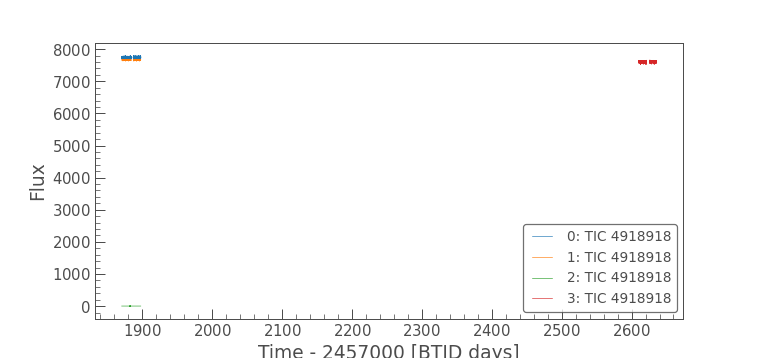

/home/orion/.local/lib/python3.8/site-packages/lightkurve/collections.py:263: LightkurveWarning: Some but not all of the light curves in the collection appear to be normalized. You may wish to use `normalize=True` to ensure all are normalized.
  warnings.warn(


<AxesSubplot:xlabel='Time - 2457000 [BTJD days]', ylabel='Flux'>

In [7]:
collect_lc.plot()

In [8]:
# Stitch the different sectors together, this '.stitch()' function also normalized the data for us
collect_lc = collect_lc.stitch()

/home/orion/.local/lib/python3.8/site-packages/lightkurve/collections.py:212: LightkurveWarning: The following columns will be excluded from stitching because the column types are incompatible: {'sap_flux', 'sap_bkg', 'sap_bkg_err'}
  warnings.warn(


<IPython.core.display.Javascript object>


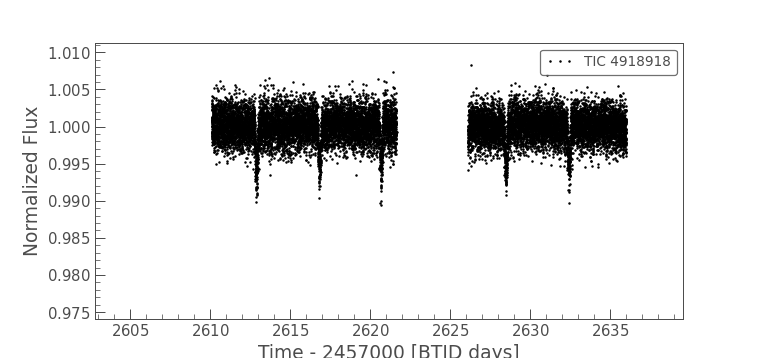

<AxesSubplot:xlabel='Time - 2457000 [BTJD days]', ylabel='Normalized Flux'>

In [9]:
collect_lc.plot(color = 'black', lw = 0, marker = '.')

<IPython.core.display.Javascript object>


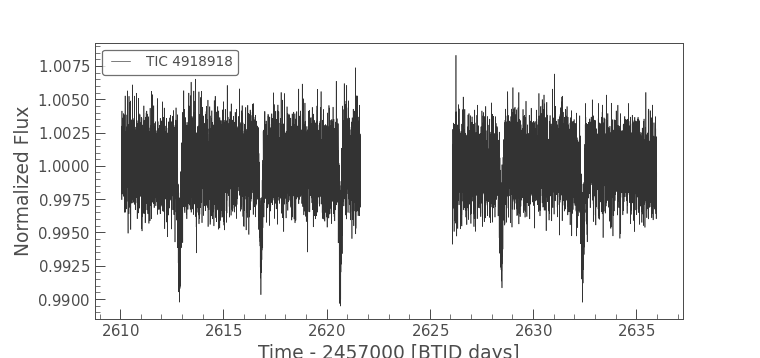

<IPython.core.display.Javascript object>


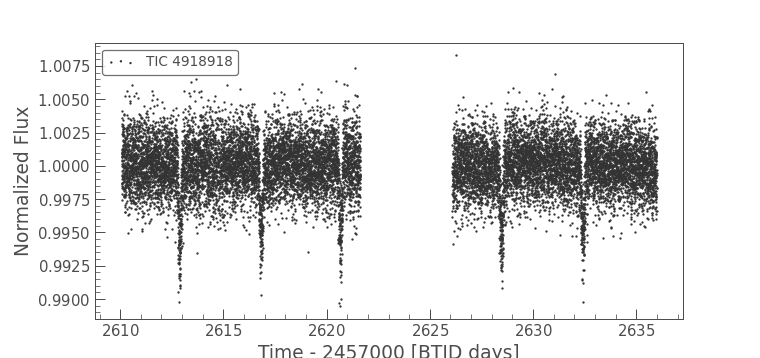

<AxesSubplot:xlabel='Time - 2457000 [BTJD days]', ylabel='Normalized Flux'>

In [10]:
#Now we will mask our lightcurves retaining only the timeframe we want.
mask = ((collect_lc.time.value < 2640)&(collect_lc.time.value > 2605)) 
masked_lc=collect_lc[mask];
masked_lc.plot();
masked_lc.scatter(s=3)

<IPython.core.display.Javascript object>


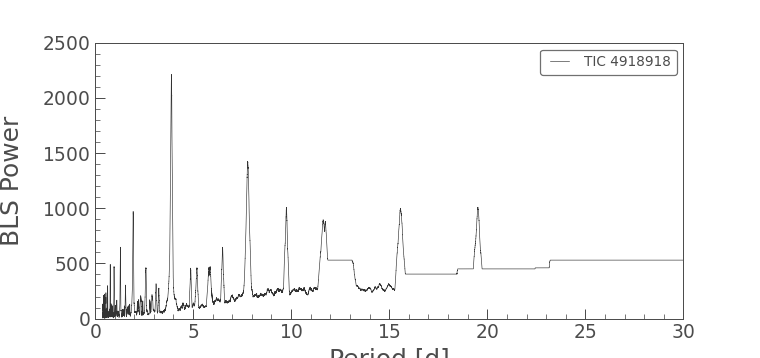

Period at max power = 3.8993469934699347 d
BLS max power = 2213.5391558898714


In [12]:
#Here we use the Box Least Square method with a periodogram to search for periodic signals and calculate the exoplanet's period
import numpy as np
import matplotlib.pyplot as plt
period = np.linspace(0.4,30, 100000) # (start,end,steps). You can change the start and end timeframe.
bls = masked_lc.to_periodogram(method='bls', period=period);
bls.plot();
plt.ylabel('BLS Power', fontsize=20, labelpad=15)
plt.xlabel('Period [d]', fontsize=20)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
#Limits on x and y axis are given manually. You may need to change them depedning on the timeframe given.
plt.xlim(0,30) 
plt.ylim([0,2500])

print('Period at max power =',bls.period_at_max_power)
print('BLS max power =', bls.max_power)

<IPython.core.display.Javascript object>


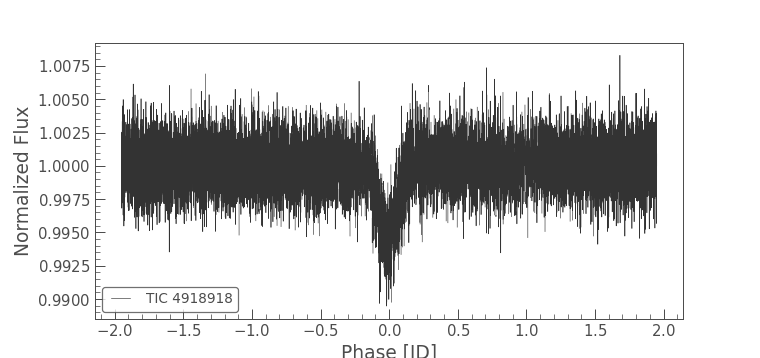

<IPython.core.display.Javascript object>


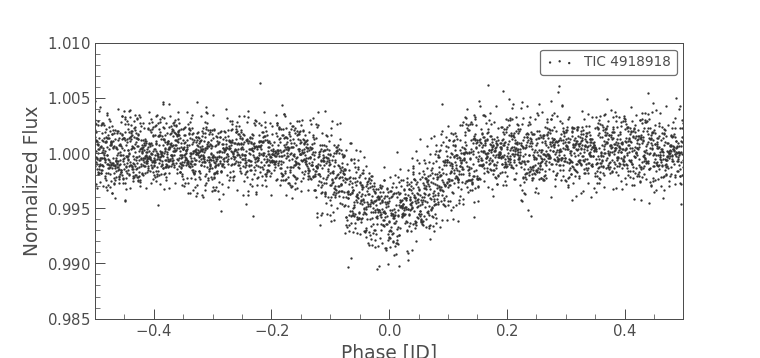

(0.985, 1.01)

In [21]:
#Here we will fold the lightcurve based on the period and the epoch time we found earlier.
#After folding your light curve you should see a signal (transit) on phase 0.
folded_lc = masked_lc.fold(bls.period_at_max_power, epoch_time=bls.transit_time_at_max_power)
folded_lc.plot();
folded_lc.scatter(s=3)
#Limits on x and y axis are given manually. You may need to change them.
plt.xlim(-0.5,0.5)
plt.ylim([0.985,1.01])

<IPython.core.display.Javascript object>


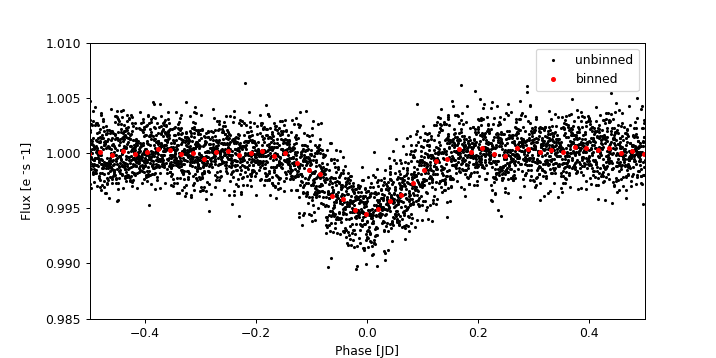

(0.985, 1.01)

In [18]:
period  = bls.period_at_max_power
t0 = bls.transit_time_at_max_power 

folded2_lc = masked_lc.fold(bls.period_at_max_power, epoch_time=bls.transit_time_at_max_power)

#Bin the folded lightcurve. Here we bin at 30 minutes.
folded2_lc_binned = folded_lc.bin(30/24/60)

fig, ax = plt.subplots(figsize = (8,4))

folded2_lc.plot(ax = ax, marker = '.', linewidth = 0, color = 'black', alpha = 1, markersize = 3)
folded2_lc_binned.plot(ax = ax, marker = 'o', linewidth = 0, color = 'red', alpha = 1, markersize = 3)
plt.legend(labels= ['unbinned', 'binned'], fontsize=10)
plt.ylabel('Flux [e ־s ־1]', fontsize=10, labelpad=10)
plt.xlabel('Phase [JD]', fontsize=10)
plt.yticks(fontsize=10)
plt.xticks(fontsize=10)
#Limits on x and y axis are given manually. You may need to change them.
plt.xlim(-0.5,0.5)
plt.ylim([0.985,1.01])

In [43]:
min = np.nanmin(folded2_lc_binned.flux) #Minimum flux of the binned lightcurve
print('Minimum flux = ', min)
median = np.nanmedian(folded2_lc_binned.flux) #Median flux of the binned lightcurve. The median flux should be equal to 1.
print('median flux =', median)
Tdepth = median - min
print('Tdepth = ', Tdepth)
print('Tdepth in ppm = ', Tdepth * (10**6), 'ppm')
ratio = np.sqrt(Tdepth)
print('Rp/Rs ratio = ', ratio) #Exoplanet's radius and Star's radius ratio.

Minimum flux =  0.9944730401039124
median flux = 1.0000988245010376
Tdepth =  0.005625784397125244
Tdepth in ppm =  5625.784397125244 ppm
Rp/Rs ratio =  0.07500522913187616


In [44]:
planet_b_period = bls.period_at_max_power
planet_b_t0 = bls.transit_time_at_max_power
planet_b_dur = bls.duration_at_max_power

In [45]:
planet_b_dur
print('Transit duration in hours=', planet_b_dur*24, 'hours')

Transit duration in hours= 4.800000000000001 d hours


In [46]:
#Transit depth from bls model
planet_b_depth = bls.depth_at_max_power
print('depth = ', planet_b_depth)
print('depth in ppm =', planet_b_depth * (10**6), 'ppm')

depth =  0.004047374814066779
depth in ppm = 4047.3748140667785 ppm


In [47]:
print(bls.period_at_max_power)
print(bls.transit_time_at_max_power)
print(bls.duration_at_max_power)

3.8993469934699347 d
2612.8862847803143
0.2 d


# Exoplanet properties calculations
Search the target's TIC ID at https://exofop.ipac.caltech.edu/tess/ to get the star's properties needed for the calculations below.

In [48]:
P = 3.8993469934699347 * 24 * 60 * 60 #planet's period
G = 6.674* 10 ** -11 #gravitational constant
Msun = 1.98847 * 10**30 #Sun mass
M = 0.415 * Msun #Star's mass
pi = math.pi
a = ((P**2)/((4*pi**2)/(G*M)))**(1/3) #Orbital radius or semi-major axis
print('Orbital Radius')
print('a =',a , 'm')
print('a =',a/1000 , 'km')
print('a =',a/1000 * 0.000000006684587, 'AU')
print('The planetary mass was neglected')

Orbital Radius
a = 5410054240.40517 m
a = 5410054.24040517 km
a = 0.036163978244707275 AU
The planetary mass was neglected


In [49]:
L = 0.02303474 #Star's luminosity
ri= (L/1.1)**(1/2)
ro= (L/0.53)**(1/2)
print('Habitable Zone')
print('The inner boundary of the habitable zone ri =', ri, 'AU')
print('The outer boundary of the habitable zone ro =', ro, 'AU')

Habitable Zone
The inner boundary of the habitable zone ri = 0.14470892414523967 AU
The outer boundary of the habitable zone ro = 0.20847487518860794 AU


In [50]:
Rs = 0.420908 #Star's radius
Transit_depth = Tdepth
Rsun  = 696340 #Sun radius
Rearth = 6371 #Earth radius
Rp = (Rs * Transit_depth ** (1/2)) * Rsun #Exoplanet's radius
print('Planet Radius')
print('Rp =', Rp, 'km')
print('Rp=',Rp/Rearth, 'Rearth')
aRs = (a/1000)/(Rs*Rsun)
print('Orbital Period and Star Radius ratio')
print('a/Rs =', aRs)

Planet Radius
Rp = 21983.66338680842 km
Rp= 3.4505828577630546 Rearth
Orbital Period and Star Radius ratio
a/Rs = 18.458359317899806


In [51]:
P = 3.8993469934699347 * 24 * 60 * 60
pi = math.pi
a = 55410054240.40517 #semi-major axis in meters
v = (2*pi*a/P)
print('Planet Velocity')
print('v =',v , 'm/s')

Planet Velocity
v = 1033386.5803078219 m/s


*** Summing up all calculated properties ***

In [52]:
print('Period = ',bls.period_at_max_power)
print('Transit duration in hours planet disk fully superimposed to the stellar disk positions 2 - 3 Tf = ', bls.duration_at_max_power*24,'hours')
print('- - - - - - - - - - - - - - - - - - - - ')
print('Transit depth = ', Tdepth)
print('Transit depth in ppm = ', Tdepth * (10**6), 'ppm')
print('Transit Depth from bls model in ppm =', planet_b_depth * (10**6), 'ppm')
ratio = np.sqrt(Tdepth)
print('Rp/Rs ratio = ', ratio)
print('- - - - - - - - - - - - - - - - - - - - ')
print('Planet Radius')
print('Rp =', Rp, 'km')
print('Rp=',Rp/Rearth, 'Rearth')
print('- - - - - - - - - - - - - - - - - - - - ')
print('Orbital Radius')
print('a =',a , 'm')
print('a =',a/1000 , 'km')
print('a =',a/1000 * 0.000000006684587, 'AU')
print('The planetary mass was neglected')
print('- - - - - - - - - - - - - - - - - - - - ')
print('Orbital Period and Star Radius ratio')
print('a/Rs', aRs)
print('- - - - - - - - - - - - - - - - - - - - ')
print('Planet Velocity')
print('v =',v , 'm/s')
print('- - - - - - - - - - - - - - - - - - - - ')


Period =  3.8993469934699347 d
Transit duration in hours planet disk fully superimposed to the stellar disk positions 2 - 3 Tf =  4.800000000000001 d hours
- - - - - - - - - - - - - - - - - - - - 
Transit depth =  0.005625784397125244
Transit depth in ppm =  5625.784397125244 ppm
Transit Depth from bls model in ppm = 4047.3748140667785 ppm
Rp/Rs ratio =  0.07500522913187616
- - - - - - - - - - - - - - - - - - - - 
Planet Radius
Rp = 21983.66338680842 km
Rp= 3.4505828577630546 Rearth
- - - - - - - - - - - - - - - - - - - - 
Orbital Radius
a = 55410054240.40517 m
a = 55410054.240405165 km
a = 0.3703933282447072 AU
The planetary mass was neglected
- - - - - - - - - - - - - - - - - - - - 
Orbital Period and Star Radius ratio
a/Rs 18.458359317899806
- - - - - - - - - - - - - - - - - - - - 
Planet Velocity
v = 1033386.5803078219 m/s
- - - - - - - - - - - - - - - - - - - - 


In [53]:
#Calculation of total transit duration Tt
Tt = ((((4 * period **(2) * Tdepth ** (1/2))/(math.pi ** 2)) * (((Rs*Rsun)/(a/1000))**(2))) + (planet_b_dur ** (2))) ** (1/2)
print('Total transit duration T14 Tt =', Tt)
print('Tt in hours =', Tt * 24, 'hours')
#Calculation of the impact parameter b for eccentricity e=0
b = (( ((1-(Tdepth **(1/2)))**(2)-(planet_b_dur/Tt)**(2))* (1+(Tdepth **(1/2)))**(2)  ) / (1 - (planet_b_dur/Tt)**(2) ) ) ** (1/2)
print('Impart parameter b =', b)
#Calculation of inclination
i = math.acos(b*(Rs*Rsun)/(a/1000))
print('Inclination i =', 90-i, 'deg')

Total transit duration T14 Tt = 0.200032328113489 d
Tt in hours = 4.800775874723736 d hours
Impart parameter b = nan
Inclination i = nan deg


In [33]:
lk.show_citation_instructions()